<a href="https://colab.research.google.com/github/aitormorais/DIPC/blob/main/Cnn_but.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar librerias

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from collections import Counter
from tqdm import tqdm

Para este cuaderno haremos uso de un [dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification)obtenido de kaggle

Lo tengo almacenado en drive, por lo que tendremos que montar el drive

Paso 1: Importar la biblioteca de drive

In [2]:
from google.colab import drive

Paso 2: Montar la carpeta

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Paso 3: Cargar datos de entrenamiento

In [5]:
train = pd.read_csv('/content/drive/MyDrive/cnn_but/Training_set.csv')

In [7]:
test = pd.read_csv('/content/drive/MyDrive/cnn_but/Testing_set.csv')

In [8]:
nombres = sorted(train['label'].unique())

Paso 5: Contamos por cada clase cuantas imagenes tenemos

In [9]:
counter = Counter(train['label'])

¿Esta la suma bien hecha?

In [10]:
assert sum(counter.values()) == len(train['label']), "La suma no está bien hecha."

Graficamos el dataset

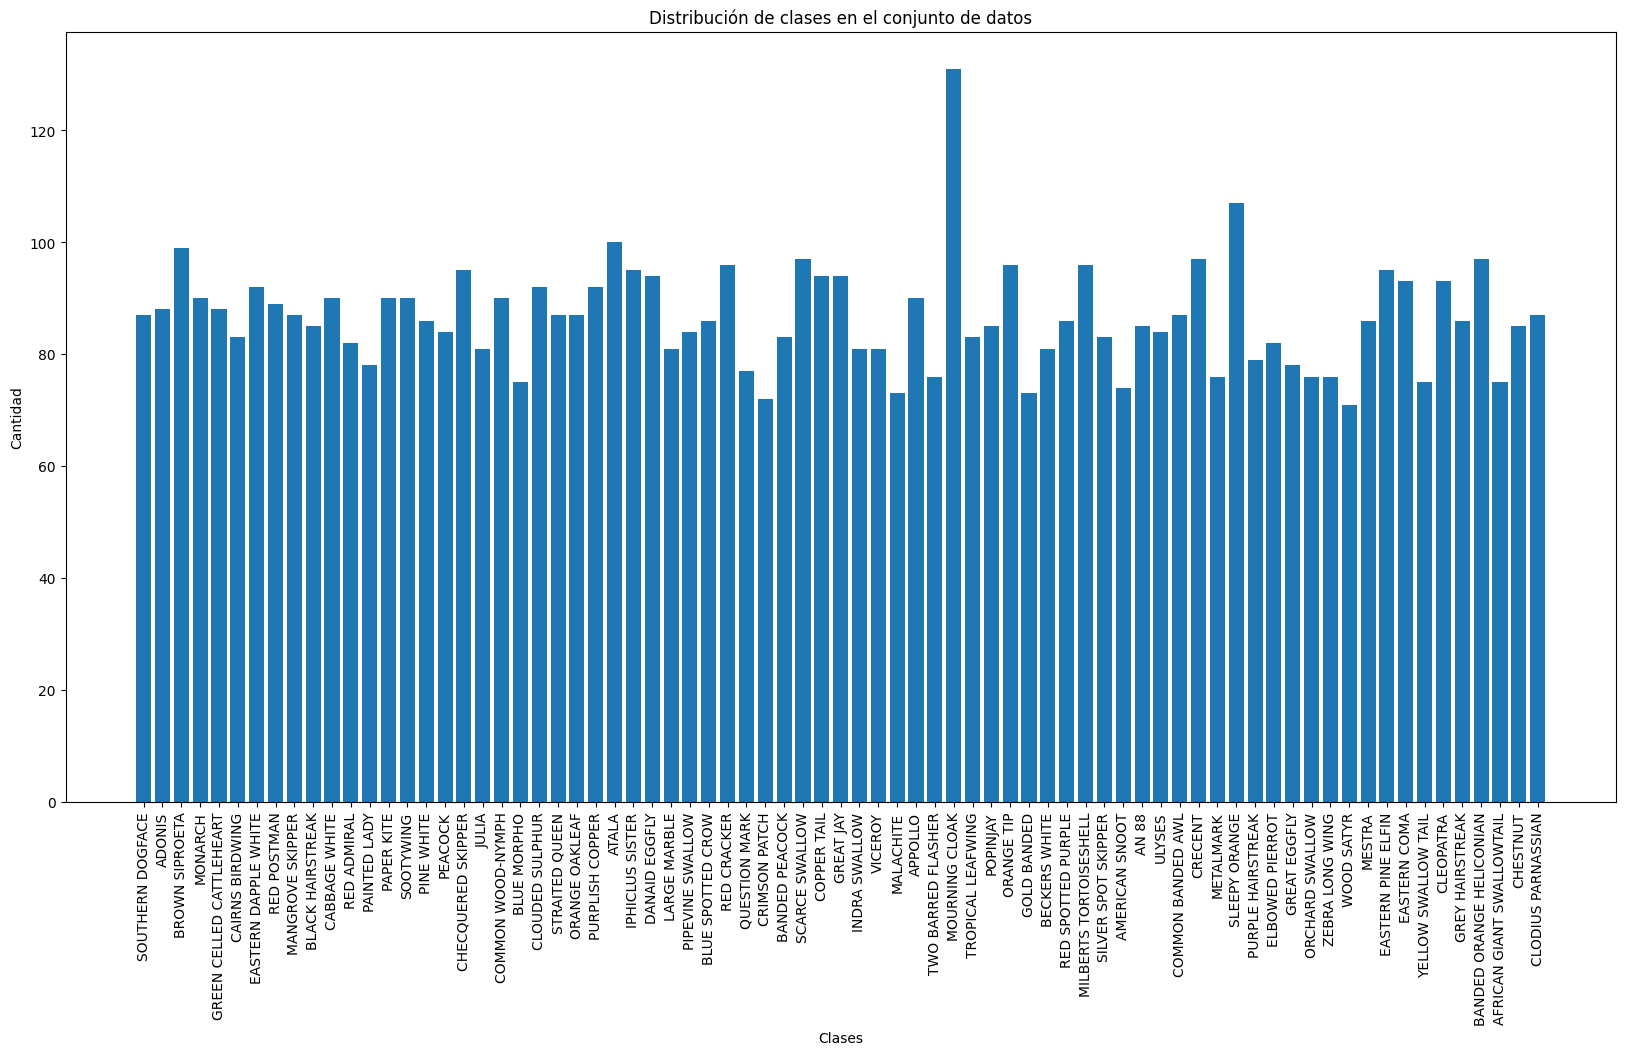

In [12]:
plt.figure(figsize=(20, 10))
plt.bar(counter.keys(), counter.values())
plt.title('Distribución de clases en el conjunto de datos')
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.xticks(rotation=90) # Esto rota los nombres de las clases en el eje x para mejorar la visibilidad
plt.show()


In [13]:
def calcular_porcentajes(counter):
    """Calcula el porcentaje de cada clase en el diccionario proporcionado."""
    total = sum(counter.values())
    return {nombre: (valor / total) * 100 for nombre, valor in counter.items()}

In [14]:
def imprimir_porcentajes(porcentajes):
    """Imprime los porcentajes en un formato legible."""
    # Imprimir los porcentajes
    for nombre, valor in porcentajes.items():
        print(f'{nombre}: {valor:.2f}%')

Imprimos el porcentaje, es decir que porcentaje representa cada clase del dataset

In [15]:
# Calcular los porcentajes
porcentajes = calcular_porcentajes(counter)

In [16]:


# Imprimir los porcentajes
imprimir_porcentajes(porcentajes)


SOUTHERN DOGFACE: 1.34%
ADONIS: 1.35%
BROWN SIPROETA: 1.52%
MONARCH: 1.38%
GREEN CELLED CATTLEHEART: 1.35%
CAIRNS BIRDWING: 1.28%
EASTERN DAPPLE WHITE: 1.42%
RED POSTMAN: 1.37%
MANGROVE SKIPPER: 1.34%
BLACK HAIRSTREAK: 1.31%
CABBAGE WHITE: 1.38%
RED ADMIRAL: 1.26%
PAINTED LADY: 1.20%
PAPER KITE: 1.38%
SOOTYWING: 1.38%
PINE WHITE: 1.32%
PEACOCK: 1.29%
CHECQUERED SKIPPER: 1.46%
JULIA: 1.25%
COMMON WOOD-NYMPH: 1.38%
BLUE MORPHO: 1.15%
CLOUDED SULPHUR: 1.42%
STRAITED QUEEN: 1.34%
ORANGE OAKLEAF: 1.34%
PURPLISH COPPER: 1.42%
ATALA: 1.54%
IPHICLUS SISTER: 1.46%
DANAID EGGFLY: 1.45%
LARGE MARBLE: 1.25%
PIPEVINE SWALLOW: 1.29%
BLUE SPOTTED CROW: 1.32%
RED CRACKER: 1.48%
QUESTION MARK: 1.18%
CRIMSON PATCH: 1.11%
BANDED PEACOCK: 1.28%
SCARCE SWALLOW: 1.49%
COPPER TAIL: 1.45%
GREAT JAY: 1.45%
INDRA SWALLOW: 1.25%
VICEROY: 1.25%
MALACHITE: 1.12%
APPOLLO: 1.38%
TWO BARRED FLASHER: 1.17%
MOURNING CLOAK: 2.02%
TROPICAL LEAFWING: 1.28%
POPINJAY: 1.31%
ORANGE TIP: 1.48%
GOLD BANDED: 1.12%
BECKERS WHITE

Empezamos con la CNN

In [4]:
def img_prepoces(ruta, tupla):
    """
    Función para leer, convertir y redimensionar una imagen utilizando OpenCV.

    Parámetros:
    - ruta (str): Una cadena que representa la ruta del archivo de imagen a procesar.
    - tupla (tuple): Un tuple que contiene dos elementos que representan la altura y el ancho (respectivamente) a los que se debe redimensionar la imagen.

    Devoluciones:
    - ndarray: Una matriz Numpy que representa la imagen procesada y normalizada.

    Esta función realiza los siguientes pasos:
    1. Lee la imagen de la ruta especificada usando `cv2.imread()`.
    2. Convierte la imagen de BGR a RGB usando `cv2.cvtColor()`.
    3. Redimensiona la imagen al tamaño especificado por la tupla usando `cv2.resize()`.
    4. Normaliza la imagen dividiéndola por 255. Esto se hace para cambiar los valores de los píxeles de la imagen de 0-255 a 0-1, un rango más adecuado para el entrenamiento de modelos de red neuronal.
    """
    img = cv2.imread(ruta)
    if img is None:
        print(f"Couldn't read the image at {ruta}.")
        return None
    return cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (tupla[0], tupla[1])) / 255

In [5]:
def construir_modelo_fc(forma_entrada, func_acti, num_capas, filtro_inicial, n_clases, n_neuronas_fc):
    """
    Función para construir una red neuronal convolucional (CNN) con Keras.

    Parámetros:
    - forma_entrada (tuple): Un tuple que define la forma de los datos de entrada (altura, ancho, canales).
    - func_acti (str): Una cadena que define la función de activación a utilizar en las capas convolucionales y densas. Ejemplos: 'relu', 'sigmoid', 'tanh'.
    - num_capas (int): Un entero que define el número de capas convolucionales a añadir a la red.
    - filtro_inicial (int): Un entero que define el número de filtros en la primera capa convolucional. Las capas convolucionales subsiguientes duplicarán el número de filtros.
    - n_clases (int): Un entero que define el número de clases objetivo para la clasificación.
    - n_neuronas_fc (int): Un entero que define el número de neuronas en la capa totalmente conectada (capa densa).

    Devoluciones:
    - model (keras.Model): El modelo de la red neuronal convolucional.
    """
    model = Sequential()
    model.add(Conv2D(filtro_inicial, (3, 3), activation=func_acti, input_shape=forma_entrada))
    model.add(MaxPooling2D((2, 2)))
    for i in range(1, num_capas):
        model.add(Conv2D(filtro_inicial*(2**i), (3, 3), activation=func_acti))
        model.add(MaxPooling2D((2, 2)))
    #Añadir capas densas
    model.add(Flatten())#importante esta capa ya que convierte 2d a 1d para capas densas
    model.add(Dense(n_neuronas_fc, activation=func_acti))
    model.add(Dropout(0.5))
    model.add(Dense(n_clases, activation='softmax'))

    return model

In [6]:
def convertir_labels_one_hot(ytrain, yval):
    """
    Esta función convierte las etiquetas categóricas de texto a formato one-hot.

    Argumentos:
        ytrain: Serie de pandas o array de NumPy que contiene las etiquetas de las muestras de entrenamiento.
        yval: Serie de pandas o array de NumPy que contiene las etiquetas de las muestras de validación.

    Retorna:
        Dos arrays de NumPy que representan las etiquetas de las muestras de entrenamiento y validación,
        respectivamente, en formato one-hot.
    """

    # Crear el codificador
    le = LabelEncoder()

    # Ajustar el codificador a las etiquetas de entrenamiento y transformar las etiquetas a números enteros
    y_train_int = le.fit_transform(ytrain)

    # Utilizar el codificador ajustado para transformar las etiquetas de validación a números enteros
    y_val_int = le.transform(yval)

    # Convertir los números enteros a formato one-hot y devolverlos
    return to_categorical(y_train_int), to_categorical(y_val_int)

In [7]:
def dimensiones(ruta):
    """
    Función para obtener las dimensiones de una imagen utilizando OpenCV.

    Parámetros:
    - ruta (str): Una cadena que representa la ruta del archivo de imagen a procesar.

    Devoluciones:
    - tuple: Un tuple que contiene las dimensiones de la imagen. El formato de la tupla devuelta es (altura, ancho, canales), donde 'canales' generalmente es 3 para imágenes en color (RGB).

    Esta función realiza los siguientes pasos:
    1. Lee la imagen de la ruta especificada usando `cv2.imread()`.
    2. Convierte la imagen de BGR a RGB usando `cv2.cvtColor()`.
    3. Devuelve la forma de la matriz de la imagen usando el atributo `.shape` de numpy, que representa las dimensiones de la imagen.
    """
    return cv2.cvtColor(cv2.imread(ruta), cv2.COLOR_BGR2RGB).shape


In [ ]:
dimensiones('/content/drive/MyDrive/Cnn_data/train/Image_1.jpg')[:2]

(224, 224)

CARGAR A LOCAL

In [1]:
import os

os.chdir('/content/')
#https://drive.google.com/file/d//view?usp=sharing
!curl -L -s -o archive.zip 'https://drive.google.com/uc?id=1GBsn30dCC_XjGwtFLyMMhnAwTLFzW3vV&confirm=t'

!unzip -q archive.zip
!rm archive.zip

print('Dataset downloaded and unzipped under /content/data')

Dataset downloaded and unzipped under /content/data


1-Dividir el dataset en train y validation

In [8]:
train = pd.read_csv('/content/Training_set.csv')

In [9]:
#crear el array donde guardaremos las imagenes en forma de matrix
train_img = []

2-Convertir las imagenes a una matrix

https://drive.google.com/file/d/10_Kqvd5Eg9Ej8N46TIm6JFb1T70RZnuM/view?usp=drive_link

https://drive.google.com/file/d/10_Kqvd5Eg9Ej8N46TIm6JFb1T70RZnuM/view?usp=sharing

In [10]:
for name in tqdm(train['filename']):
    nombre = "/content/train/"+name
    train_img.append(img_prepoces(nombre,dimensiones(nombre)[:2]))

100%|██████████| 6499/6499 [00:20<00:00, 315.45it/s]


3-Guardar las etiquetas

In [11]:
names = train['label']

4-Dividir los datos

In [12]:
X_train_img, X_val_img, y_train_names, y_val_names = train_test_split(train_img, names, test_size=0.2, random_state=42)

In [ ]:
del train_img

Resize:
 se espera que las imagenes de entrada esten en un array 4d, con forma (numero de imagenes,altura,ancho,canales)

In [ ]:
X_train_img = np.array(X_train_img).reshape(-1, 224, 224, 3)
X_val_img = np.array(X_val_img).reshape(-1, 224, 224, 3)

Definimos los parametros para hacer uso del data augmentation

In [ ]:
# Crear un generador de datos de imagen con aumentación
datagen = ImageDataGenerator(
        rotation_range=30,  # Rotar aleatoriamente las imágenes
        zoom_range = 0.1, # Zoom aleatoriamente las imágenes dentro del rango
        width_shift_range=0.1,  # Desplazar aleatoriamente las imágenes horizontalmente
        height_shift_range=0.1,  # Desplazar aleatoriamente las imágenes verticalmente
        horizontal_flip=True,  # Invertir aleatoriamente las imágenes horizontalmente
        vertical_flip=False)  # No invertir las imágenes verticalmente

Ajustamos el generador de datos a los datos de entrenamiento

In [ ]:
datagen.fit(X_train_img)

Convertimos las etiquetas a formato one-hot

In [ ]:
y_train_names,y_val_names = convertir_labels_one_hot(y_train_names, y_val_names)

Callbacks

In [ ]:
callbacks = [
    ModelCheckpoint("mejor.h5", save_best_only=True),  # Guarda el mejor modelo como 'mejor_modelo.h5'
    EarlyStopping(patience=10, restore_best_weights=True),  # Detén el entrenamiento si el modelo deja de mejorar
    ReduceLROnPlateau(patience=5)  # Reduce la tasa de aprendizaje si el modelo deja de mejorar
]


Creamos el modelo

In [ ]:
modelo = construir_modelo_fc((224,224,3),'relu',4,16,75,512)

Compilamos el modelo

In [ ]:
modelo.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy','precision'])


In [ ]:
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Entrenamos el modelo

In [ ]:
history = modelo.fit(datagen.flow(X_train_img, y_train_names, batch_size=32),
                    validation_data=(X_val_img, y_val_names),
                    steps_per_epoch=len(X_train_img) // 32,
                    epochs=100)

In [ ]:
modelo.save('mejor_modelo.keras')